In [908]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.options.mode.chained_assignment = None

# Applied Machine Learning
In this assignment we will explore a dataset about soccer players and referees, focusing predictions and clustering essentially on the players' skin color.

## Preprocessing

Let's have a look at the data:

In [909]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.ix[:5,:14]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0,0


In [910]:
data.ix[:5,15:]

,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


### NaN values

In [911]:
data.isnull().sum()

playerShort          0
player               0
club                 0
leagueCountry        0
birthday             0
height             263
weight            2243
position         17726
games                0
victories            0
ties                 0
defeats              0
goals                0
yellowCards          0
yellowReds           0
redCards             0
photoID          21407
rater1           21407
rater2           21407
refNum               0
refCountry           0
Alpha_3              1
meanIAT            163
nIAT               163
seIAT              163
meanExp            163
nExp               163
seExp              163
dtype: int64

In [912]:
filtered = data.dropna()

In [913]:
len(filtered)/len(data)

0.790649738406333

If we would decide to simply discard all the NaN values, we would keep only 21% of the DataSet. We are mainly interested in the skin color of each player so we will have a closer look at the `rater1` and `rater2` skin rating columns.

### Skin Color

In [914]:
len(data[data.rater1.isnull() & (data.rater2.isnull())])/len(data)

0.14659517352836443

15% of the dataset will be discarded as it doesn't give any information about the skin color.

In [915]:
skin_data = data.dropna(how='all', subset=['rater1','rater2'])

In [916]:
len(skin_data[skin_data.rater1.isnull() | (skin_data.rater2.isnull())])

0

We can observe that there were always values for both `rater1` and `rater2` or not any values. Let's have a look at the data for which the raters gave a different skin color.

In [917]:
skin_data_differ = skin_data[skin_data.rater1 != skin_data.rater2]

In [918]:
len(skin_data_differ)/len(skin_data)

0.23195930059941744

For 23% of the player the two raters gave a different value. Let's see if they gave skin colors that are almost the same or opposite skin colors:

In [919]:
skin_data['skin_difference'] = skin_data.apply(lambda x: abs(x['rater1'] - x['rater2']), axis=1)

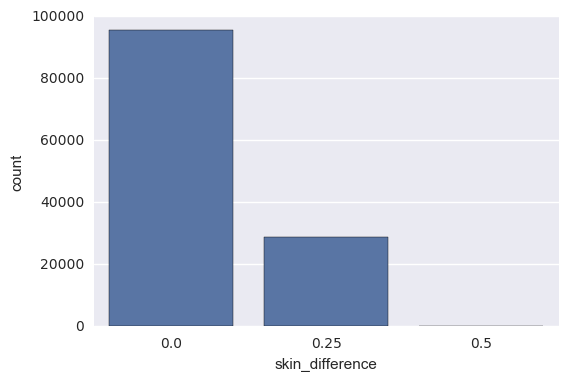

In [920]:
palette = sns.color_palette()
sns.countplot(x="skin_difference", data=skin_data, color=palette[0]);

If the two raters differ, it is only by one on the 5-point scale or by 2. We decide to keep the average value of the two raters on a 0 to 4 scale.

In [921]:
skin_data['skin'] = skin_data.apply(lambda x: round((x['rater1']+x['rater2'])/2*4), axis=1)

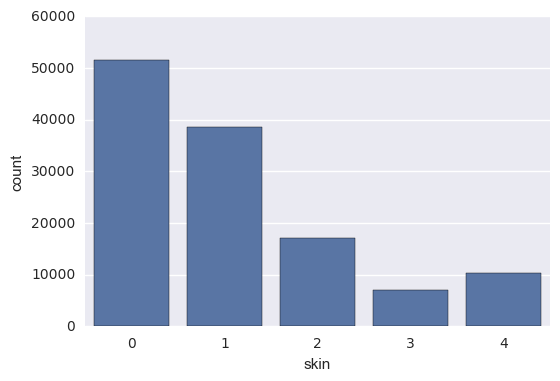

In [922]:
sns.countplot(x="skin", data=skin_data, color=palette[0]);

We can observe that the raters are probably not that accurate as the data is skewed.

### Birthday
There are not any missing birthday value. We will have a look at the distribution.

In [923]:
# The birthday string is converted into a datetime type
import datetime
skin_data['birthday'] = skin_data.apply(lambda x: datetime.datetime.strptime(x['birthday'], "%d.%m.%Y"), axis=1)

In [924]:
skin_data['birthday'].head()

0   1983-08-31
1   1982-01-08
5   1979-11-08
6   1985-11-10
7   1986-04-04
Name: birthday, dtype: datetime64[ns]

In [925]:
# We will plot number of birthdays per month:
birthdays = pd.DataFrame()
birthdays['birthday'] = skin_data.apply(lambda x: (x['birthday'] - np.timedelta64(x['birthday'].day-1,'D')), axis=1)

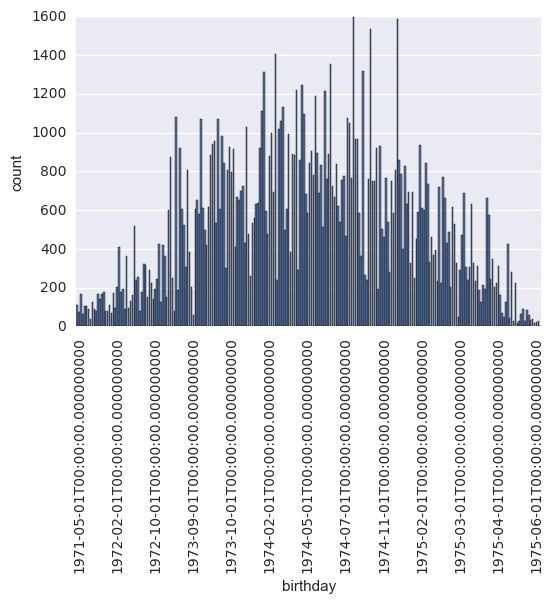

In [895]:
p = sns.countplot(x="birthday", data=birthdays, color=palette[0])
plt.setp(p.get_xticklabels(), rotation=90)
p.set(xticks=np.arange(1,244,20));

Everything seems fine for the date values.

### League Country

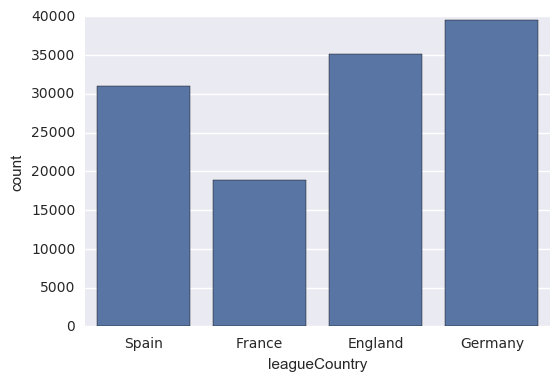

In [926]:
sns.countplot(x="leagueCountry", data=skin_data, color=palette[0]);

### Height

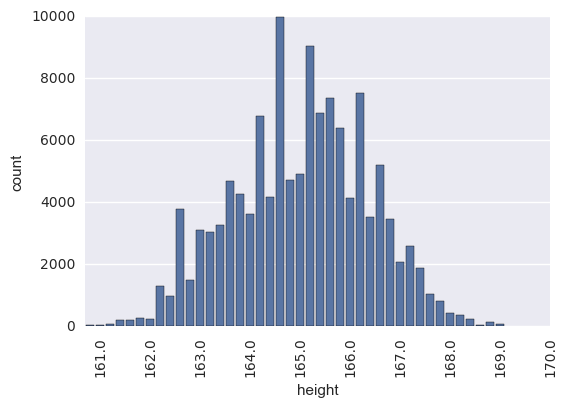

In [927]:
h = sns.countplot(x="height", data=skin_data, color=palette[0])
plt.setp(h.get_xticklabels(), rotation=90)
h.set(xticks=np.arange(1,48,5));

There is no outliers and the distribution looks normal.

### Weight

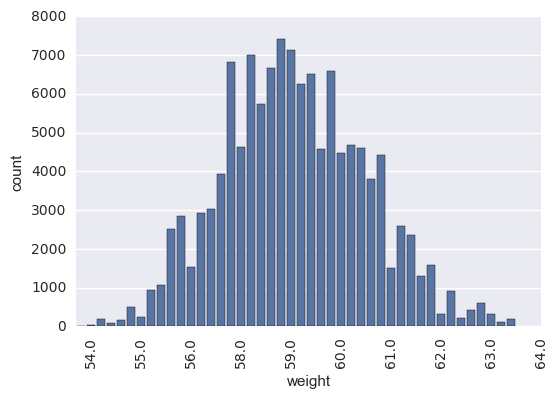

In [928]:
w = sns.countplot(x="weight", data=skin_data, color=palette[0])
plt.setp(w.get_xticklabels(), rotation=90)
w.set(xticks=np.arange(1,50,5));

### Position 

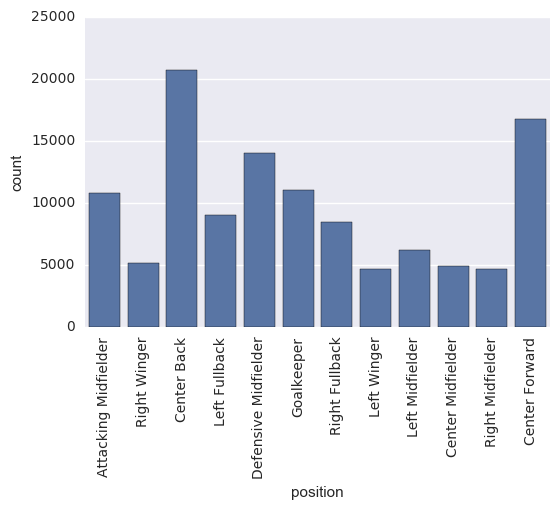

In [929]:
pos = sns.countplot(x="position", data=skin_data, color=palette[0]);
plt.setp(pos.get_xticklabels(), rotation=90);

In [930]:
missing_values = skin_data['position'].isnull().value_counts()

In [931]:
missing_values[1]/missing_values[0]

0.072839187327823685

7% of the positions are missing. We will replace them by the most by a category `Missing Position`.

### Referees

In [932]:
print('There are ' + str(len(skin_data['refNum'].value_counts())) + ' different referees.')

There are 2978 different referees.


In [933]:
print('Which come from ' + str(len(skin_data['refCountry'].value_counts())) + ' different countries...')

Which come from 160 different countries...


### Standardization, Categorical Features Encoding and Replacing Missing Values

We transform each feature into a representation that is more suitable for the machine learning methods. Each feature will be **standardized** if it is a float number (remove mean value, scale dividing by standard deviation) using the `StandardScaler()` function from `sklearn`. If there are missing values, they will be replaced by the mean, which is 0 after applying the StandardScaler. The categorical features will be **encoded** using the `LabelEncoder()` function which converts categorical variable into numerical values. The learning models consider continuous values and don't handle categorical features, but we hope it RandomForest will be robust again those values. The missing categorical variables are replaced by `Missing Category`. We discard the name of the player.

In [934]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer 
from sklearn.feature_extraction import DictVectorizer

# Discard names of players and photoID
skin_data = skin_data.drop(labels=['playerShort','player', 'photoID'], axis=1)

# Replacing missing values for categorical data:
skin_data['position'] = skin_data['position'].fillna('Missing Position')
# For the Alpha_3 there is only one missing value so we will drop it
skin_data = skin_data.dropna(subset=['Alpha_3'])

# Features to be standardized
stand = ['birthday', 'height', 'weight', 'games', 'victories', 'ties', 'defeats','goals', 'yellowCards', 'redCards', 'meanIAT','nIAT','seIAT','meanExp','nExp','seExp']
# Categorical features to be encoded
cat = ['club', 'leagueCountry', 'position', 'Alpha_3']

# Encode categories
for c in cat:
    skin_data[c] = LabelEncoder().fit_transform(skin_data[s])

# The first function fills the missing values and the second one will apply the standardization 
for s in stand:
    skin_data[s] = Imputer(strategy='mean', axis=1).fit_transform(skin_data[s])[0]
    skin_data[s] = StandardScaler().fit_transform(skin_data[s])

In [935]:
skin_data.head()

,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,...,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skin_difference,skin
0,34,34,-0.396639,-0.753342,-0.609486,34,-0.556813,-0.714223,-0.625047,0.044991,...,1,34,-0.677683,-0.138498,-0.013506,-0.309476,-0.139678,-0.014768,0.25,2
1,116,116,-0.773317,-0.459377,0.785829,116,-0.556813,-0.714223,-0.625047,0.044991,...,2,116,-4.513948,-0.143828,2.140990,-3.048676,-0.145090,2.969357,0.00,3
5,84,84,-1.270531,-0.018431,-0.749017,84,-0.556813,-0.714223,-0.625047,0.044991,...,4,84,-0.715302,-0.143138,0.557507,0.340820,-0.144465,0.546239,0.25,0
6,84,84,0.106853,0.716480,0.506766,84,-0.556813,-0.182282,-0.625047,-0.657796,...,4,84,-0.715302,-0.143138,0.557507,0.340820,-0.144465,0.546239,0.25,0
7,84,84,0.197884,-0.312395,-1.167612,84,-0.556813,-0.714223,-0.625047,0.044991,...,4,84,-0.715302,-0.143138,0.557507,0.340820,-0.144465,0.546239,0.00,4


# 1. Random Forest Skin Color Classifier

We split the data for the training set and the testing set.

In [937]:
skin_data['is_train'] = np.random.uniform(0, 1, len(skin_data)) <= .75
train, test = skin_data[skin_data['is_train']==True], skin_data[skin_data['is_train']==False]

In [938]:
# Skin to predict
skin = train['skin'].values.ravel()

All the columns will be used to train the Random Forest Classifier. We need to drop the `rater1`, `rater2`, `skin` and `skin_difference` values as we want to predict the `skin`.

In [939]:
to_predict = ['rater1', 'rater2', 'skin', 'skin_difference', 'is_train']
train = train.drop(labels=to_predict, axis=1)
features = train.columns

We train a simple random forest classifier

In [940]:
tree = RandomForestClassifier().fit(train, skin)

We check its accuracy on the testing set:

In [941]:
preds = tree.predict(test[features])

In [942]:
pd.crosstab(test['skin'], preds, rownames=['actual'], colnames=['preds'])

preds,0,1,2,3,4
actual,,,,,
0,11719,897,206,52,114
1,1829,7605,143,55,71
2,879,523,2702,39,79
3,420,233,88,978,48
4,596,305,89,42,1579


In [944]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), tree.feature_importances_), features), reverse=True))

Features sorted by their score:
[(0.28089999999999998, 'birthday'), (0.18579999999999999, 'weight'), (0.1812, 'height'), (0.095399999999999999, 'refNum'), (0.036999999999999998, 'games'), (0.035099999999999999, 'victories'), (0.029899999999999999, 'defeats'), (0.026200000000000001, 'ties'), (0.025000000000000001, 'goals'), (0.0235, 'yellowCards'), (0.0088999999999999999, 'meanExp'), (0.0083000000000000001, 'refCountry'), (0.0074999999999999997, 'leagueCountry'), (0.0073000000000000001, 'meanIAT'), (0.0071999999999999998, 'Alpha_3'), (0.0064999999999999997, 'position'), (0.0064000000000000003, 'nIAT'), (0.0061999999999999998, 'nExp'), (0.0061999999999999998, 'club'), (0.0054000000000000003, 'seIAT'), (0.0051999999999999998, 'seExp'), (0.0025000000000000001, 'redCards'), (0.0023, 'yellowReds')]
